# Count Model Analysis 1

In this script, we will perform an analysis of different models for count data using the statsmodels library. We will use the "corruption" dataset as an example. We will apply Poisson, Negative Binomial, and their variations with zero inflation and compare their results.

Additionally, we will conduct tests to assess the presence of overdispersion and zero inflation in the data. These pieces of information are crucial for determining the most suitable model to be applied to count data.

The objective is to evaluate and select the best-fitting model that takes into account the specific characteristics of the "corruption" dataset.

## Dataset Description

The dataset used was obtained from a [study](https://www.journals.uchicago.edu/doi/abs/10.1086/527495) on cultural norms and legal enforcement in controlling corruption, focusing on the parking behavior of United Nations officials in Manhattan.

Until 2002, diplomatic immunity protected UN diplomats from parking enforcement actions, so their actions were only constrained by cultural norms. However, after that year, enforcement authorities acquired the right to confiscate diplomatic license plates of violators.

The dataset includes the number of violations (occurring in different countries) as the dependent variable, and the number of staff, the corruption index of the country, and a categorical variable (post) indicating whether the observation of the delegation in question was made before or after the change in the law as the predictor variables.

The dataset has proven effective for studying models for count data due to the fact that the dependent variable consists of positive integer numbers.

## Implementation

- Investigating Dataset


- Descriptive Statistics


- Defining the Best Model (and Tests)


- Interpreting the Results

***

## Checking the Dataset

In [1]:
# Libraries Needed
import scipy
import pandas as pd
from scipy import stats
import numpy as np
import math
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
warnings.filterwarnings("ignore")

In [2]:
# Checking DataFrame
df = pd.read_csv(f'Data/corruption.csv', index_col=0)
df.head(5)

,country,code,violations,staff,post,corruption
1,Angola,AGO,50,9,no,1.047506
2,Angola,AGO,1,9,yes,1.047506
3,Albania,ALB,17,3,no,0.921079
4,Albania,ALB,0,3,yes,0.921079
5,United Arab Emirates,ARE,0,3,no,-0.779468


In [3]:
# Transforming 'post'
df['post'] = pd.factorize(df['post'])[0]
df.head(5)

,country,code,violations,staff,post,corruption
1,Angola,AGO,50,9,0,1.047506
2,Angola,AGO,1,9,1,1.047506
3,Albania,ALB,17,3,0,0.921079
4,Albania,ALB,0,3,1,0.921079
5,United Arab Emirates,ARE,0,3,0,-0.779468


In [4]:
# Keeping relevant columns
df = df[['staff', 'post', 'corruption', 'violations']]
df.head(5)

,staff,post,corruption,violations
1,9,0,1.047506,50
2,9,1,1.047506,1
3,3,0,0.921079,17
4,3,1,0.921079,0
5,3,0,-0.779468,0


In [5]:
# Checking data types
df.dtypes

staff           int64
post            int64
corruption    float64
violations      int64
dtype: object

In [6]:
# Checking null values
df.isna().sum()

staff         0
post          0
corruption    0
violations    0
dtype: int64

## Descriptive statistics

In [7]:
# Cecking violations mean and variance
df['violations'].mean(), df['violations'].var()

(6.496644295302014, 331.61783381917587)

As we can see, the variance being much greater than the mean is a strong indication of overdispersion.

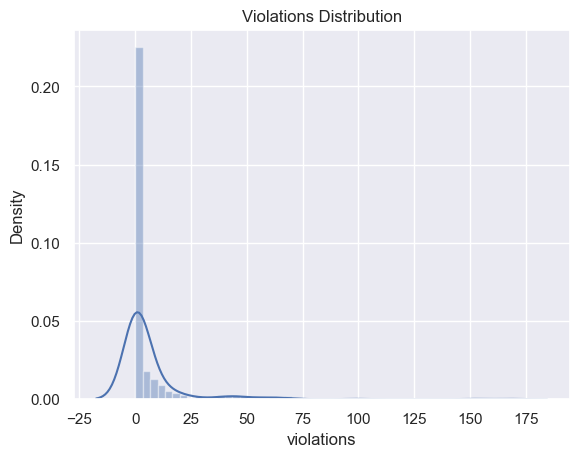

In [8]:
# Plotting dependent variable distribution
sns.distplot(df['violations'])
plt.title('Violations Distribution');

The dependent variable (violations) shows a considerable number of zeros. Tests will be necessary, but indications suggest that the model with the best fit to the data is the Zero-Inflated Negative Binomial model.

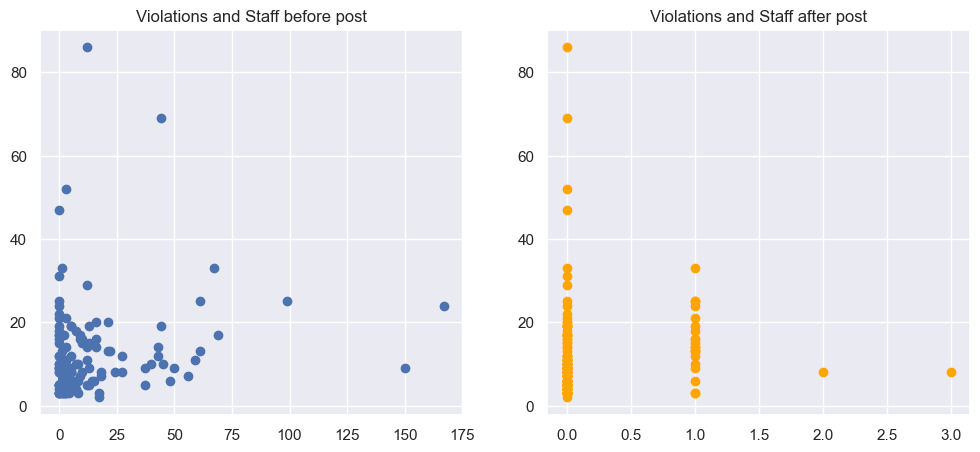

In [9]:
# Plotting the Violations and Staff before and after the post
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df['violations'].loc[df['post'] == 0], df['staff'].loc[df['post'] == 0])
axes[0].set_title('Violations and Staff before post')
axes[1].scatter(df['violations'].loc[df['post'] == 1], df['staff'].loc[df['post'] == 1], color='orange')
axes[1].set_title('Violations and Staff after post')
plt.show()

## Defining the Best Model

The Poisson, Negative Binomial, and their variations with zero-inflation models will be applied to the data, and the Log Likelihood will be used as the metric to evaluate the quality of the fit.

There is strong evidence that the ideal model will be the Zero-Inflated Negative Binomial, considering the high observed dispersion and the high number of zeros. However, initially, tests will be conducted.

Starting with the Cameron and Trivedi test, which aims to observe the presence of overdispersion. To perform the test, the Poisson model needs to be created and fitted to the dataset.

In [10]:
# Spliting Variables into predictors and dependent
X = df.drop('violations', 1).values
y = df['violations'].values

In [11]:
# Creating Poisson Model
poisson_model = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Mon, 29 May 2023   Deviance:                       3644.0
Time:                        16:14:54   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2127      0.031     71.134      0.0

In [12]:
# Poisson Fitted Values
poisson_fitted = poisson_model.fittedvalues
poisson_fitted[0:5]

array([15.91991512,  0.21671089, 13.37172024,  0.18202342,  7.47791499])

The Cameron and Trivedi test for overdispersion is an approach used to assess whether a Poisson model exhibits overdispersion. It involves calculating the Pearson statistic, which measures the difference between the observed and expected values adjusted by the model.

Then, an auxiliary linear regression model is fitted, with the Pearson statistic as the dependent variable and the adjusted expected values as the independent variable.

A hypothesis test is conducted to determine if the coefficient of the predictor is statistically different from zero, indicating the presence of overdispersion in the data. It is important to consult specialized literature for specific details on implementing this test.

In [13]:
# Calculating pearson stat
pearson_stat = (((df['violations'] - poisson_fitted)**2)-df['violations'])/poisson_fitted

In [14]:
# Creating the aux model
aux_model = sm.OLS(pearson_stat, poisson_fitted).fit()
aux_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             violations   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Mon, 29 May 2023   Prob (F-statistic):                     0.00625
Time:                        16:14:55   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6525      0.963      2.754      0.006       0.757       4.548
==============================================================================
Omnibus:                      607.263   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           446004.649
Skew:                          13.265   Prob(JB):                         0.00
Kurtosis:                     190.659   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a coefficient in the auxiliary model having a p-value of 0.006, and considering that the Cameron and Trivedi test for overdispersion aims to detect the presence of this phenomenon, we can conclude that there is statistically significant evidence of overdispersion in the Poisson model.

The Poisson model will not be the most efficient for this dataset; therefore, a Negative Binomial model will be created and fitted.

In [15]:
# Creating Negative Binomial Model
bneg_model = sm.NegativeBinomial(y, sm.add_constant(X)).fit()
print(bneg_model.summary())

Optimization terminated successfully.
         Current function value: 1.904031
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                  298
Model:               NegativeBinomial   Df Residuals:                      294
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 May 2023   Pseudo R-squ.:                  0.1549
Time:                        16:14:55   Log-Likelihood:                -567.40
converged:                       True   LL-Null:                       -671.37
Covariance Type:            nonrobust   LLR p-value:                 8.088e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9469      0.205      

From the value of the log likelihood (the closer to zero, the better), we can observe that this model appears to be considerably better than the Poisson model. However, it is also necessary to test for zero-inflation in the data. For this purpose, the Vuong test will be used.

To proceed with the Vuong test, a Zero-Inflated Negative Binomial model needs to be created. This model accounts for both overdispersion and excess zeros in the data. The Zero-Inflated Negative Binomial model combines a binary model (logistic regression) to model the presence of excess zeros and a count model (Negative Binomial regression) to model the count data. 

In [16]:
# Creating Zero-Inflated Negative Binomial Model 
zinb_model = sm.ZeroInflatedNegativeBinomialP(y, sm.add_constant(X), exog_infl=sm.add_constant(X), method='nm', maxiter=10000).fit(method='newton')
print(zinb_model.summary())

Optimization terminated successfully.
         Current function value: 1.876075
         Iterations 12
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                  298
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      294
Method:                                      MLE   Df Model:                            3
Date:                           Mon, 29 May 2023   Pseudo R-squ.:                  0.1673
Time:                                   16:14:55   Log-Likelihood:                -559.07
converged:                                  True   LL-Null:                       -671.37
Covariance Type:                       nonrobust   LLR p-value:                 2.025e-48
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const

After fitting the model and interpreting its outputs, it can be observed that, unlike the Poisson and Negative Binomial models, the ZINB model has coefficients that are not statistically significant.

The p-values associated with the first two variables (staff and post) in the inflationary part, as well as the p-value associated with the last variable (corruption), are greater than 0.05. This indicates that these variables are not statistically significant for the model, considering a significance level of 5%. Therefore, a new model will be created excluding these variables.

In [17]:
# Creating Zero-Inflated Negative Binomial Model (Relevant variables)
zinb_model = sm.ZeroInflatedNegativeBinomialP(endog=y,
                                    exog=sm.add_constant(np.delete(X, [2], 1)),
                                    exog_infl=sm.add_constant(np.delete(X, [0,1], 1))).fit()
print(zinb_model.summary())

         Current function value: 1.872522
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                  298
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      295
Method:                                      MLE   Df Model:                            2
Date:                           Mon, 29 May 2023   Pseudo R-squ.:                  0.1689
Time:                                   16:14:55   Log-Likelihood:                -558.01
converged:                                 False   LL-Null:                       -671.37
Covariance Type:                       nonrobust   LLR p-value:                 5.847e-50
                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [18]:
# Function for vuong test
def vuong_test(mod1, mod2, correction=True):
    '''
    mod1, mod2 - non-nested logitstic regression fit results from statsmodels
    '''
    # number of observations and check of models
    N = mod1.nobs
    N2 = mod2.nobs
    if N != N2:
        raise ValueError('Models do not have the same number of observations')
        
    # extract the log-likelihood for individual points with the models
    m1 = mod1.model.loglikeobs(mod1.params)
    m2 = mod2.model.loglikeobs(mod2.params)
    
    # point-wise log likelihood ratio
    m = m1 - m2
    
    # calculate the LR statistic
    LR = np.sum(m)
    
    # calculate the AIC and BIC correction factors -> these go to zero when df is same between models
    AICcor = mod1.df_model - mod2.df_model
    BICcor = np.log(N)*AICcor/2
    
    # calculate the omega^2 term
    omega2 = np.var(m, ddof=1)
    
    # calculate the Z statistic with and without corrections
    Zs = np.array([LR,LR-AICcor,LR-BICcor])
    Zs /= np.sqrt(N*omega2)
    
    # P vals
    ps = []
    msgs = []
    for Z in Zs:
        if Z>0:
            ps.append(1 - stats.norm.cdf(Z))
            msgs.append('model 1 preferred over model 2')
        else:
            ps.append(stats.norm.cdf(Z))
            msgs.append('model 2 preferred over model 1')
 
    # Information
    print('=== Vuong Test Results ===')
    labs = ['Uncorrected']
    if AICcor!=0:
        labs += ['AIC Corrected','BIC Corrected']
    for lab,msg,p,Z in zip(labs,msgs,ps,Zs):
        print('  -> '+lab)
        print('    -> '+msg)
        print('    -> Z: '+str(Z))
        print('    -> p: '+str(p))

In [19]:
# Applying the Vuong test for zinb and bneg models
vuong_test(zinb_model, bneg_model)

=== Vuong Test Results ===
  -> Uncorrected
    -> model 1 preferred over model 2
    -> Z: 1.4014305166586813
    -> p: 0.08054268600903436
  -> AIC Corrected
    -> model 1 preferred over model 2
    -> Z: 1.5506816624544655
    -> p: 0.060488995580165184
  -> BIC Corrected
    -> model 1 preferred over model 2
    -> Z: 1.8265793819419966
    -> p: 0.033881517871839684


According to the results of the Vuong test, using different corrections, it is indicated that the ZINB model is preferred over the Negative Binomial model in all cases. This is suggested by the positive Z statistics and p-values greater than 0.05.

Therefore, the ZINB model appears to be the ideal model for this dataset. However, for comparison purposes, a ZIP (Zero-Inflated Poisson) model will also be fitted to the data.

In [20]:
# Creating ZIP model
zip_model = sm.ZeroInflatedPoisson(endog=y,
                                    exog=sm.add_constant(X),
                                    exog_infl=sm.add_constant(X)).fit()
print(zip_model.summary())

         Current function value: 5.976352
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Mon, 29 May 2023   Pseudo R-squ.:                  0.1977
Time:                         16:14:55   Log-Likelihood:                -1781.0
converged:                       False   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                6.190e-190
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -1.3823      0.390     -3.547      0.000     

Once again, some coefficients have been found to be statistically insignificant and will be disregarded.

In [21]:
# Creating ZIP model
zip_model = sm.ZeroInflatedPoisson(endog=y,
                                    exog=sm.add_constant(X),
                                    exog_infl=sm.add_constant(np.delete(X, [0,1], 1))).fit()
print(zip_model.summary())

Optimization terminated successfully.
         Current function value: 5.977545
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Mon, 29 May 2023   Pseudo R-squ.:                  0.1975
Time:                         16:14:55   Log-Likelihood:                -1781.3
converged:                        True   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                8.828e-190
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -1.6116

## Interpreting the Results

Considering the log-likelihood of the models, the ZINB model had the best fit, as expected, since zero inflation and overdispersion were observed in the data. The Negative Binomial model also had a good fit.

In [22]:
# Creating DataFrame
df_ll = pd.DataFrame(index=['Poisson', 'Bneg', 'ZIP', 'ZINB'])
df_ll['loglike'] = [poisson_model.llf, bneg_model.llf, zip_model.llf, zinb_model.llf]
df_ll

,loglike
Poisson,-2071.793753
Bneg,-567.401172
ZIP,-1781.308425
ZINB,-558.011425


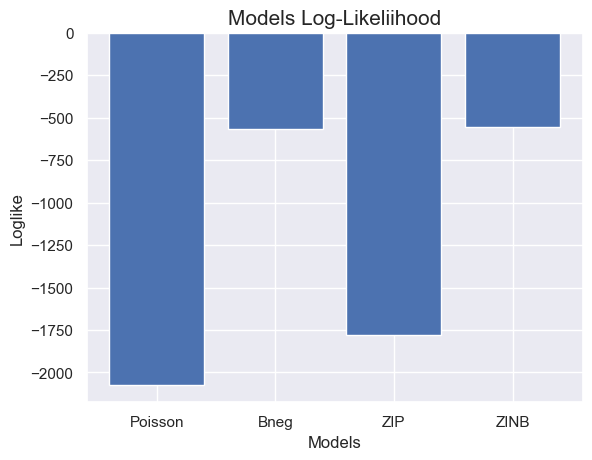

In [23]:
# Plotting Models LL over bars
plt.bar(df_ll.index, df_ll['loglike'])
plt.xlabel('Models')
plt.ylabel('Loglike')
plt.title('Models Log-Likeliihood', size=15);

The values and the graph show that these two models had a considerably lower log likelihood (indicating better fit) compared to the Poisson and ZIP models.